In [1]:
import os
import sys

import torch.nn as nn
import torch.optim as optim
import torchvision
from sklearn.decomposition import PCA
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision.datasets import MNIST

# tell jupyter where are local modules are
module_path = os.path.abspath('.')
if module_path not in sys.path:
    sys.path.append(module_path)

from dae import DAE, Naive_DAE
from demo_train_utils import train_rbm
from rbm import RBM
from utils import *

# Setup

In [2]:
print(f"Using device {DEVICE}")
seed_everything(42)

MNIST_DIR = "/home/ubuntu/efs/mnist/" # directory to store MNIST data. Set it here.
MNIST_NUM_PIXELS = 784 # 28x28

Using device cuda


# Load Data

In [3]:
train = MNIST(MNIST_DIR, train=True, download=False, transform=torchvision.transforms.ToTensor())
test = MNIST(MNIST_DIR, train=False, download=False, transform=torchvision.transforms.ToTensor())
train_dl = DataLoader(train, batch_size=1, shuffle=False)
test_dl = DataLoader(test, batch_size=1, shuffle=False)

Flatten images to a 784-dimensional vector (28x28)

In [4]:
def flatten_input(dl):
    flat_input = []
    labels = []
    for features, targets in train_dl:
        features = Variable(features.view(-1, MNIST_NUM_PIXELS))
        flat_input.append(features.detach().cpu().numpy())
        labels.append(targets.detach().cpu().numpy())
    return np.concatenate(flat_input), np.concatenate(labels)
flat_train_input, train_labels = flatten_input(train_dl)
flat_test_input, test_labels = flatten_input(test_dl)
train_dl_flat = DataLoader(TensorDataset(torch.Tensor(flat_train_input).to(DEVICE), torch.Tensor(flat_train_input).to(DEVICE)), batch_size=64, shuffle=False)

# Naive Deep Autoencoder

This autoencoder does a very poor job and gets stuck at a generic implementation!

Epoch 0: 0.06847720702828121
Epoch 1: 0.06762878499083173
Epoch 2: 0.06748990681586362
Epoch 3: 0.0674124685511279
Epoch 4: 0.06737074981540886
Epoch 5: 0.06735461656806438
Epoch 6: 0.06734865248949924
Epoch 7: 0.06734402700940938
Epoch 8: 0.06734298227597148
Epoch 9: 0.067342362289172
Original (top) and Reconstructed (bottom)


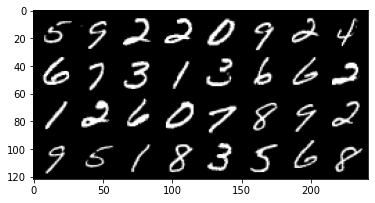

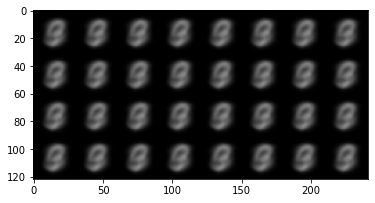

In [5]:
# fine-tune autoencoder
lr = 1e-3
dae = Naive_DAE([784,1000,500,250,2]).to(DEVICE)
loss = nn.MSELoss()
optimizer = optim.Adam(dae.parameters(), lr)
num_epochs = 10

# train
running_loss = float("inf")
for epoch in range(num_epochs):
    losses = []
    for i, (data, target) in enumerate(train_dl_flat): 
        v_pred = dae(data)
        batch_loss = loss(data, v_pred) # difference between actual and reconstructed   
        losses.append(batch_loss.item())
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
    running_loss = np.mean(losses)
    print(f"Epoch {epoch}: {running_loss}")
    if epoch % 10 == 9:
        # show visual progress every 10 epochs
        display_output(data, v_pred, v0_fname="original_digits.png", vk_fname="reconstructed_digits_naive_dae.png")

# Train RBMs
Let's pretrain some RBMs first. The layers we will train are: 784-1000-500-250-2 

In [6]:
hidden_dimensions = [
    {
        "hidden_dim": 1000, 
        "num_epochs": 10, 
        "learning_rate": 0.1, 
        "display_dim1": 28, 
        "display_dim2": 28, 
        "use_gaussian": False
    }, 
    {
        "hidden_dim": 500, 
        "num_epochs": 10, 
        "learning_rate": 0.1, 
        "display_dim1": 25, 
        "display_dim2": 40, 
        "use_gaussian": False
    },
    {
        "hidden_dim": 250, 
        "num_epochs": 10, 
        "learning_rate": 0.1, 
        "display_dim1": 25, 
        "display_dim2": 20, 
        "use_gaussian": False
    },
    {
        "hidden_dim": 2, 
        "num_epochs": 30, 
        "learning_rate": 0.001, # use much lower LR for gaussian to avoid exploding gradient
        "display_dim1": 25, 
        "display_dim2": 10, 
        "use_gaussian": True # use a Gaussian distribution for the last hidden layer to let it take advantage of continuous values
    }
]

Train RBMs

784 to 1000
epoch 0: 0.015347630716860294
epoch 1: 0.010446857661008835
epoch 2: 0.009759824723005295
epoch 3: 0.009408839046955109
epoch 4: 0.009181097149848938
epoch 5: 0.010241469368338585
epoch 6: 0.00949448999017477
epoch 7: 0.009167659096419811
epoch 8: 0.008976656943559647
epoch 9: 0.008800506591796875
Original (top) and Reconstructed (bottom)


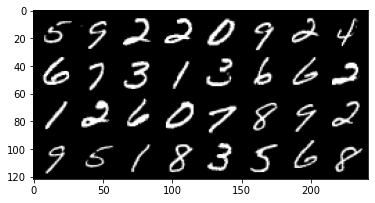

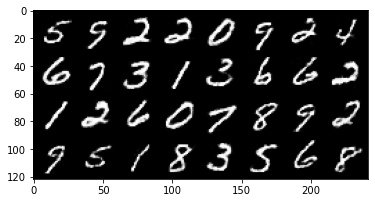

1000 to 500
epoch 0: 0.016363656148314476
epoch 1: 0.010145891457796097
epoch 2: 0.009004943072795868
epoch 3: 0.008314858190715313
epoch 4: 0.00781769584864378
epoch 5: 0.007564211264252663
epoch 6: 0.0064721605740487576
epoch 7: 0.0060445452108979225
epoch 8: 0.005839519202709198
epoch 9: 0.005705634597688913
Original (top) and Reconstructed (bottom)


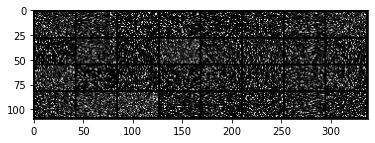

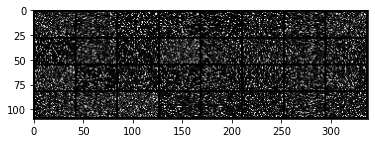

500 to 250
epoch 0: 0.022105492651462555
epoch 1: 0.013584809377789497
epoch 2: 0.012407849542796612
epoch 3: 0.011832897551357746
epoch 4: 0.011463073082268238
epoch 5: 0.012142929248511791
epoch 6: 0.011300789192318916
epoch 7: 0.010859250091016293
epoch 8: 0.01054081879556179
epoch 9: 0.010346491821110249
Original (top) and Reconstructed (bottom)


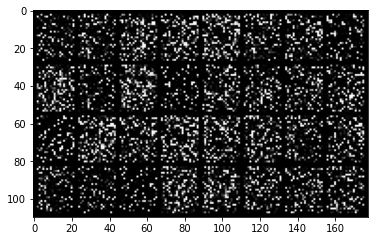

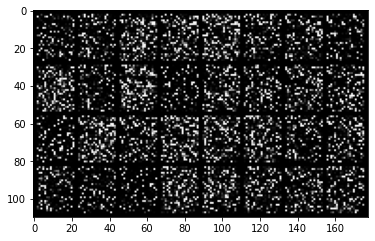

250 to 2
epoch 0: 0.16478082537651062
epoch 1: 0.13966414332389832
epoch 2: 0.1333799809217453
epoch 3: 0.13050304353237152
epoch 4: 0.12900182604789734
epoch 5: 0.12751111388206482
epoch 6: 0.12678313255310059
epoch 7: 0.12667149305343628
epoch 8: 0.12663987278938293
epoch 9: 0.126645028591156
epoch 10: 0.126623272895813
epoch 11: 0.12664546072483063
epoch 12: 0.126627117395401
epoch 13: 0.12664413452148438
epoch 14: 0.12663304805755615
epoch 15: 0.1266380250453949
epoch 16: 0.1266345977783203
epoch 17: 0.12662917375564575
epoch 18: 0.12663650512695312
epoch 19: 0.12664581835269928
epoch 20: 0.12663288414478302
epoch 21: 0.1266411393880844
epoch 22: 0.12662509083747864
epoch 23: 0.12663951516151428
epoch 24: 0.12663470208644867
epoch 25: 0.1266394406557083
epoch 26: 0.12662097811698914
epoch 27: 0.12663215398788452
epoch 28: 0.12664180994033813
epoch 29: 0.12662771344184875
Original (top) and Reconstructed (bottom)


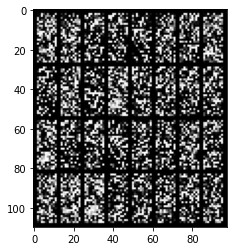

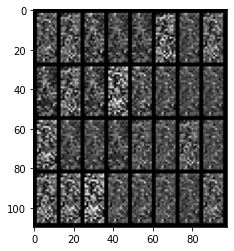

In [7]:
# get initial iteration of new training dl
new_train_dl = train_dl_flat

visible_dim = MNIST_NUM_PIXELS
hidden_dim = None
models = [] # trained RBM models
for configs in hidden_dimensions:
    
    # parse configs
    hidden_dim = configs["hidden_dim"]
    num_epochs = configs["num_epochs"]
    lr = configs["learning_rate"]
    d1 = configs["display_dim1"]
    d2 = configs["display_dim2"]
    use_gaussian = configs["use_gaussian"]
    
    # train RBM
    print(f"{visible_dim} to {hidden_dim}")
    model, v, v_pred = train_rbm(new_train_dl, visible_dim, hidden_dim, k=1, num_epochs=num_epochs, lr=lr, use_gaussian=use_gaussian)
    models.append(model)
    
    # display sample output
    display_output(v, v_pred, d1, d2)

    # rederive new data loader based on hidden activations of trained model
    new_data = []
    for features, targets in new_train_dl:
        p, sample = model.sample_h(features)
        new_data.append(p.detach().cpu().numpy())
    new_input = np.concatenate(new_data)
    new_train_dl = DataLoader(TensorDataset(torch.Tensor(new_input).to(DEVICE), torch.Tensor(new_input).to(DEVICE)), batch_size=64, shuffle=False)
    
    # update new visible_dim for next RBM
    visible_dim = hidden_dim

# Fine-tune Deep Autoencoder from built from RBMs

/home/ubuntu/miniconda3/envs/kaggle/lib/python3.8/site-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


Epoch 0: 0.04623604919324552
Epoch 1: 0.040328773773158154
Epoch 2: 0.038182665141168304
Epoch 3: 0.037007547934839465
Epoch 4: 0.03630820307920355
Epoch 5: 0.03570778181812148
Epoch 6: 0.03518282642949428
Epoch 7: 0.034901485776405596
Epoch 8: 0.034570185922340416
Epoch 9: 0.03439924124080235
Original (top) and Reconstructed (bottom)


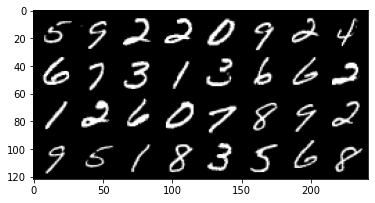

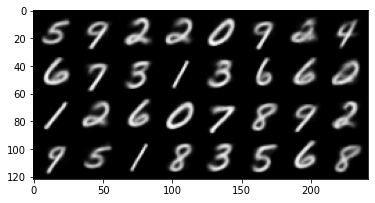

Epoch 10: 0.034175509136162206
Epoch 11: 0.033833112202282904
Epoch 12: 0.03356930818448443
Epoch 13: 0.033475748418188934
Epoch 14: 0.033304940436535806
Epoch 15: 0.033148415064983276
Epoch 16: 0.03290759077442607
Epoch 17: 0.032705186836437375
Epoch 18: 0.03269723793471863
Epoch 19: 0.032537511287769404
Original (top) and Reconstructed (bottom)


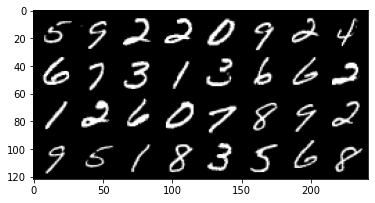

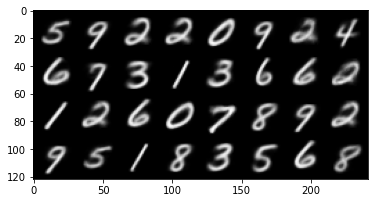

Epoch 20: 0.032502489230001784
Epoch 21: 0.03239651884176711
Epoch 22: 0.03237337059279812
Epoch 23: 0.03211183908349797
Epoch 24: 0.03216182464944211
Epoch 25: 0.03206618742814768
Epoch 26: 0.031777510123609354
Epoch 27: 0.031735599596998586
Epoch 28: 0.0318165120503891
Epoch 29: 0.03154266384174066
Original (top) and Reconstructed (bottom)


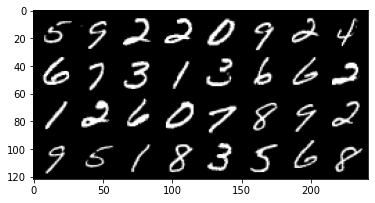

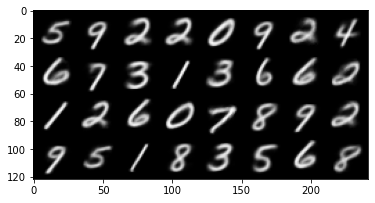

Epoch 30: 0.031560399549713396
Epoch 31: 0.031444780286282364
Epoch 32: 0.03143360834719657
Epoch 33: 0.031246955083536188
Epoch 34: 0.03127756853824231
Epoch 35: 0.03131707552780729
Epoch 36: 0.031098410838654937
Epoch 37: 0.031067304283396394
Epoch 38: 0.030910100190163547
Epoch 39: 0.030926551137651716
Original (top) and Reconstructed (bottom)


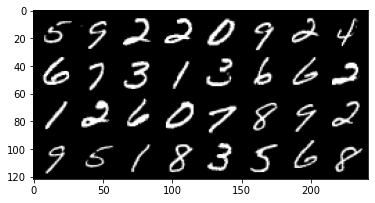

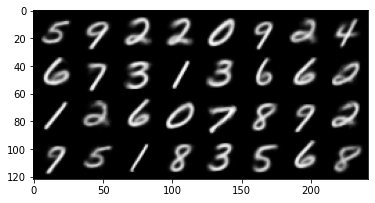

Epoch 40: 0.030992632261169616
Epoch 41: 0.030734395326327667
Epoch 42: 0.030747723084554743
Epoch 43: 0.030710930828807322
Epoch 44: 0.030486656622941307
Epoch 45: 0.03054379246064595
Epoch 46: 0.0303363741508552
Epoch 47: 0.03041858037016285
Epoch 48: 0.030281269202020757
Epoch 49: 0.030266161732026127
Original (top) and Reconstructed (bottom)


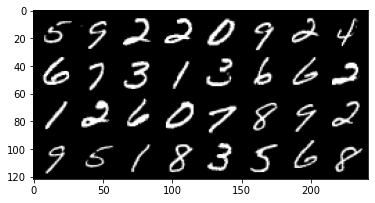

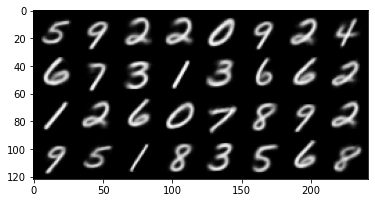

In [11]:
# fine-tune autoencoder
lr = 1e-3
dae = DAE(models).to(DEVICE)
loss = nn.MSELoss()
optimizer = optim.Adam(dae.parameters(), lr)
num_epochs = 50

# train
running_loss = float("inf")
for epoch in range(num_epochs):
    losses = []
    for i, (data, target) in enumerate(train_dl_flat): 
        v_pred = dae(data)
        batch_loss = loss(data, v_pred) # difference between actual and reconstructed   
        losses.append(batch_loss.item())
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
    running_loss = np.mean(losses)
    print(f"Epoch {epoch}: {running_loss}")
    if epoch % 10 == 9:
        # show visual progress every 10 epochs
        display_output(data, v_pred, v0_fname="original_digits.png", vk_fname="reconstructed_digits_dae.png")

# Plot Learned 2d Representations

Here we plot the learned 2d representations on test data. For comparison, we also show the results from PCA

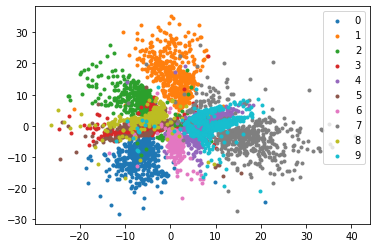

In [9]:
transformed = dae.encode(torch.Tensor(flat_test_input[0:5000]).to(DEVICE)).detach().cpu().numpy()
display_2d_repr(transformed, test_labels, "dae_repr.png")

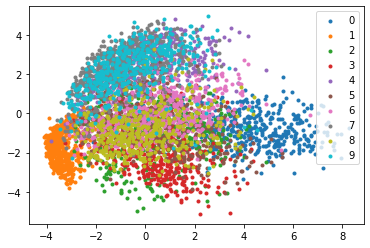

In [10]:
pca = PCA(n_components=2, random_state=10)
pca.fit(flat_train_input)
transformed = pca.transform(flat_test_input[0:5000])
display_2d_repr(transformed, test_labels, "pca_repr.png")